In [1]:
import os
import librosa
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from io import BytesIO
import base64


# Function to fetch all MP3 files from subfolders
def get_audio_files(folder_path):
    print("Fetching audio files...")
    audio_files = []
    album_names = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".mp3"):
                audio_files.append(os.path.join(root, file))
                if OTHER_SONGS_FOLDER in root:
                    album_names.append(None)
                else:
                    album_names.append(os.path.basename(root))
    return audio_files, album_names

# Print Cluster-Wise Song Lists
def print_clusterwise_songs(song_clusters, song_names):
    print("\nCluster-Wise Song Lists:")
    cluster_map = defaultdict(list)
    for song, cluster in zip(song_names, song_clusters):
        cluster_map[cluster].append(song)
    for cluster, songs in cluster_map.items():
        print(f"Cluster {cluster}:")
        for song in songs:
            print(f"  - {song}")

# Print Cluster-Wise Album Lists
def print_clusterwise_albums(album_clusters, album_names):
    print("\nCluster-Wise Album Lists:")
    cluster_map = defaultdict(list)
    for album, cluster in zip(album_names, album_clusters):
        cluster_map[cluster].append(album)
    for cluster, albums in cluster_map.items():
        print(f"Cluster {cluster}:")
        for album in albums:
            print(f"  - {album}")

# Function to extract features
def extract_features(file_list):
    print("Extracting features...")
    features = []
    valid_files = []
    for file in file_list:
        print(file)
        try:
            y, sr = librosa.load(file, sr=None)
            y, _ = librosa.effects.trim(y, top_db=20)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            rms = librosa.feature.rms(y=y)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y=y)
            tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            feature_vector = np.hstack([
                np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(rms), np.std(rms),
                np.mean(chroma, axis=1), np.std(chroma, axis=1),
                np.mean(spectral_contrast, axis=1), np.std(spectral_contrast, axis=1),
                np.mean(zcr), np.std(zcr),
                tempo, np.std(np.diff(beat_frames) / sr),
                np.mean(onset_env), np.std(onset_env)
            ])
            features.append(feature_vector)
            valid_files.append(file)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    return np.array(features), valid_files


# Function to rank songs by similarity
def rank_songs_by_similarity(features, song_names):
    print("Ranking songs by similarity using all features...")
    
    # Ensure features are normalized (already done during feature extraction)
    average_feature_vector = np.mean(features, axis=0)
    distances = [np.linalg.norm(feature - average_feature_vector) for feature in features]

    ranked_songs = sorted(zip(distances, song_names), key=lambda x: x[0])

    print("\nSongs Ranked by Similarity to Average Sound (Most to Least):")
    for rank, (distance, song) in enumerate(ranked_songs, start=1):
        print(f"{rank}. {song} (Distance: {distance:.4f})")

    return ranked_songs

def rank_songs_by_similarity_pca(features, song_names, pca_dimensions):
    print("Ranking songs by similarity...")
    pca = PCA(n_components=pca_dimensions)
    reduced_features = pca.fit_transform(features)

    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"\nPCA Explained Variance (Songs): {explained_variance:.2f}%")

    average_feature_vector = np.mean(reduced_features, axis=0)
    distances = [np.linalg.norm(feature - average_feature_vector) for feature in reduced_features]

    ranked_songs = sorted(zip(distances, song_names), key=lambda x: x[0])

    print("\nSongs Ranked by Similarity to Average Sound (Most to Least):")
    for rank, (distance, song) in enumerate(ranked_songs, start=1):
        print(f"{rank}. {song} (Distance: {distance:.4f})")

    return ranked_songs

# Function to cluster data
def cluster_data(features, n_clusters, pca_dimensions):
    print(f"Clustering into {n_clusters} clusters...")
    pca = PCA(n_components=pca_dimensions)
    reduced_features = pca.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    labels = kmeans.fit_predict(reduced_features)

    return labels, reduced_features, pca

def map_songs_to_albums(folder_path, other_songs_folder):
    """
    Create a map of song names to their respective albums based on the folder structure.
    Songs in the `Other Songs` folder will have album as None.
    """
    print("Mapping songs to albums...")
    song_album_map = {}
    for root, _, files in os.walk(folder_path):
        album_name = None if other_songs_folder in root else os.path.basename(root)
        for file in files:
            if file.endswith(".mp3"):
                song_name = os.path.splitext(file)[0]  # Remove the .mp3 extension
                song_album_map[song_name] = album_name
    return song_album_map

def generate_html_report(ranked_songs, song_clusters, album_clusters, song_names, album_names, song_img, album_img, album_similarity_data, song_to_album_similarity):
    print("Generating HTML report...")

    # Prepare HTML for Top 10 Most and Least Linkin Park Songs
    most_similar_html = ''.join([f"<li>{rank + 1}. {song}</li>" for rank, (distance, song) in enumerate(ranked_songs[:10])])
    least_similar_html = ''.join([f"<li>{rank + 1}. {song}</li>" 
                                  for rank, (distance, song) in enumerate(ranked_songs[-10:][::-1])])  # Reverse the last 10

    # Prepare HTML for Song Clusters
    song_clusters_html = ""
    for cluster_id, cluster_name in enumerate(SONG_CLUSTER_NAMES):
        songs_in_cluster = [song for song, cluster in zip(song_names, song_clusters) if cluster == cluster_id]
        song_list_html = ', '.join(songs_in_cluster)
        song_clusters_html += f"""
        <tr>
            <td>{cluster_name}</td>
            <td>{song_list_html}</td>
        </tr>
        """

    # Prepare HTML for Album Clusters
    album_clusters_html = ""
    for cluster_id, cluster_name in enumerate(ALBUM_CLUSTER_NAMES):
        albums_in_cluster = [album for album, cluster in zip(album_names, album_clusters) if cluster == cluster_id]
        album_list_html = ''.join([f"<li>{album}</li>" for album in albums_in_cluster])
        album_clusters_html += f"""
        <tr>
            <td>{cluster_name}</td>
            <td><ul>{album_list_html}</ul></td>
        </tr>
        """

    # Prepare HTML for Album Similarity Data
    album_similarity_html = ""
    for album_name, data in album_similarity_data.items():
        most_similar = data["most_similar_song"]
        least_similar = data["least_similar_song"]
        most_similar_outside = data["most_similar_song_outside_album"] or "N/A"
        least_similar_outside = data["least_similar_song_outside_album"] or "N/A"
        album_similarity_html += f"""
        <tr>
            <td>{album_name}</td>
            <td>{most_similar}</td>
            <td>{least_similar}</td>
            <td>{most_similar_outside}</td>
            <td>{least_similar_outside}</td>
        </tr>
        """

    # Prepare HTML for Song-to-Album Similarity Data (filtered)
    filtered_song_to_album_similarity = {}
    song_album_map = map_songs_to_albums(folder_path, OTHER_SONGS_FOLDER)
    for song_name, album_name in song_to_album_similarity.items():
        actual_album = song_album_map[song_name]
        # Include song if:
        # 1. It belongs to "Other Songs" (actual_album is None).
        # 2. The closest album is not its actual album.
        if (actual_album == 'Other Songs' or album_name != actual_album) and song_name!="Across the Line":
            filtered_song_to_album_similarity[song_name] = album_name

    # Generate HTML for the filtered results
    song_to_album_similarity_html = ""
    for song_name, album_name in filtered_song_to_album_similarity.items():
        song_to_album_similarity_html += f"""
        <tr>
            <td>{song_name}</td>
            <td>{album_name}</td>
        </tr>
        """

    # Combine all HTML content
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Linkin Park Song Clustering Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f4f4f9; color: #333; }}
            h1, h2 {{ color: #4CAF50; }}
            table {{ width: 100%; border-collapse: collapse; margin-bottom: 20px; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #4CAF50; color: white; }}
            img {{ max-width: 100%; height: auto; }}
            ul {{ list-style-type: none; padding: 0; }}
            li {{ padding: 5px 0; }}
        </style>
    </head>
    <body>
        <h1>Linkin Park Song Clustering Report</h1>
        
        <h2>3D Visualization of Songs</h2>
        <img src="data:image/png;base64,{song_img}" alt="3D Visualization of Songs">
        
        <h2>Cluster-Wise Songs</h2>
        <table>
            <tr>
                <th>Cluster Name</th>
                <th>Songs</th>
            </tr>
            {song_clusters_html}
        </table>

        <h2>Top 10 Most Linkin Park Songs</h2>
        <ul>{most_similar_html}</ul>
        
        <h2>Top 10 Least Linkin Park Songs</h2>
        <ul>{least_similar_html}</ul>
        
        <h2>3D Visualization of Albums</h2>
        <img src="data:image/png;base64,{album_img}" alt="3D Visualization of Albums">
        
        <h2>Cluster-Wise Albums</h2>
        <table>
            <tr>
                <th>Cluster Name</th>
                <th>Albums</th>
            </tr>
            {album_clusters_html}
        </table>
        
        <h2>Album Similarity Data</h2>
        <table>
            <tr>
                <th>Album</th>
                <th>Which Song in this Album is most similar to it?</th>
                <th>Which Song in this Album is least similar to it?</th>
                <th>Which Song outside this Album is most similar to it?</th>
                <th>Which Song outside this Album is least similar to it?</th>
            </tr>
            {album_similarity_html}
        </table>
        
        <h2>Song-to-Album Similarity</h2>
        <table>
            <tr>
                <th>Song</th>
                <th>Which album is most similar to this song?</th>
            </tr>
            {song_to_album_similarity_html}
        </table>
    </body>
    </html>
    """

    # Write the HTML content to a file
    report_path = "linkin_park_clustering_report.html"
    with open(report_path, "w") as file:
        file.write(html_content)
    print(f"HTML report generated: {report_path}")


# Function to save plots as Base64
def save_plot_as_base64(fig):
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")


def generate_album_song_data(album_features, song_features, song_names, album_names_unique, album_names):
    print("Generating album and song similarity data...")
    
    album_similarity_data = {}
    song_to_album_similarity = {}

    # Convert album_features and song_features to numpy arrays for efficient operations
    album_features = np.array(album_features)
    song_features = np.array(song_features)

    # For each album
    for i, album_name in enumerate(album_names_unique):
        # Get the feature vector for the current album
        album_vector = album_features[i]
        
        # Find songs in this album
        songs_in_album = [song_features[j] for j, album in enumerate(album_names) if album == album_name]
        song_indices_in_album = [j for j, album in enumerate(album_names) if album == album_name]

        # Calculate similarity (Euclidean distance) for songs in the album
        distances_in_album = [np.linalg.norm(song - album_vector) for song in songs_in_album]
        
        # Find most and least similar songs in the album
        most_similar_idx = np.argmin(distances_in_album)
        least_similar_idx = np.argmax(distances_in_album)
        most_similar_song_in_album = song_names[song_indices_in_album[most_similar_idx]]
        least_similar_song_in_album = song_names[song_indices_in_album[least_similar_idx]]

        # Calculate similarity for songs outside the album
        songs_outside_album = [song_features[j] for j, album in enumerate(album_names) if album != album_name]
        song_indices_outside_album = [j for j, album in enumerate(album_names) if album != album_name]
        distances_outside_album = [np.linalg.norm(song - album_vector) for song in songs_outside_album]

        # Find the most similar song outside the album
        if distances_outside_album:  # Check to avoid issues with empty lists
            most_similar_idx_outside = np.argmin(distances_outside_album)
            most_similar_song_outside_album = song_names[song_indices_outside_album[most_similar_idx_outside]]
        else:
            most_similar_song_outside_album = None

        # Find the least similar song outside the album
        if distances_outside_album:  # Check to avoid issues with empty lists
            least_similar_idx_outside = np.argmax(distances_outside_album)
            least_similar_song_outside_album = song_names[song_indices_outside_album[least_similar_idx_outside]]
        else:
            least_similar_song_outside_album = None

        # Store results for the album
        album_similarity_data[album_name] = {
            "most_similar_song": most_similar_song_in_album,
            "least_similar_song": least_similar_song_in_album,
            "most_similar_song_outside_album": most_similar_song_outside_album,
            "least_similar_song_outside_album": least_similar_song_outside_album  # New key
        }

    # For each song
    for i, song_name in enumerate(song_names):
        song_vector = song_features[i]

        # Calculate similarity (Euclidean distance) to each album
        distances_to_albums = [np.linalg.norm(song_vector - album_vector) for album_vector in album_features]

        # Find the most similar album
        most_similar_album_idx = np.argmin(distances_to_albums)
        most_similar_album = album_names_unique[most_similar_album_idx]

        # Store results for the song
        song_to_album_similarity[song_name] = most_similar_album

    return album_similarity_data, song_to_album_similarity

In [3]:
# Configurable parameters
OTHER_SONGS_FOLDER = "Other Songs"  # Special folder name for other songs
folder_path = "Song Folder"

In [4]:
audio_files, album_names = get_audio_files(folder_path)
# Step 1: Extract Features
song_features, valid_files = extract_features(audio_files)


Fetching audio files...
Extracting features...
Song Folder/LIVING THINGS/LIES GREED MISERY.mp3
Song Folder/LIVING THINGS/VICTIMIZED.mp3
Song Folder/LIVING THINGS/CASTLE OF GLASS.mp3
Song Folder/LIVING THINGS/UNTIL IT BREAKS.mp3
Song Folder/LIVING THINGS/IN MY REMAINS.mp3
Song Folder/LIVING THINGS/POWERLESS.mp3
Song Folder/LIVING THINGS/ROADS UNTRAVELED.mp3
Song Folder/LIVING THINGS/SKIN TO BONE.mp3
Song Folder/LIVING THINGS/I'LL BE GONE.mp3
Song Folder/LIVING THINGS/BURN IT DOWN.mp3
Song Folder/LIVING THINGS/LOST IN THE ECHO.mp3
Song Folder/Minutes to Midnight/In Pieces.mp3
Song Folder/Minutes to Midnight/The Little Things Give You Away.mp3
Song Folder/Minutes to Midnight/No More Sorrow.mp3
Song Folder/Minutes to Midnight/What I've Done.mp3
Song Folder/Minutes to Midnight/Shadow of the Day.mp3
Song Folder/Minutes to Midnight/Leave Out All The Rest.mp3
Song Folder/Minutes to Midnight/In Between.mp3
Song Folder/Minutes to Midnight/Hands Held High.mp3
Song Folder/Minutes to Midnight/Valen

In [7]:
# Step 2: Prepare song names
song_names = [os.path.basename(f)[:-4] for f in valid_files]
song_names

['LIES GREED MISERY',
 'VICTIMIZED',
 'CASTLE OF GLASS',
 'UNTIL IT BREAKS',
 'IN MY REMAINS',
 'POWERLESS',
 'ROADS UNTRAVELED',
 'SKIN TO BONE',
 "I'LL BE GONE",
 'BURN IT DOWN',
 'LOST IN THE ECHO',
 'In Pieces',
 'The Little Things Give You Away',
 'No More Sorrow',
 "What I've Done",
 'Shadow of the Day',
 'Leave Out All The Rest',
 'In Between',
 'Hands Held High',
 "Valentine's Day",
 'Given Up',
 'Bleed It Out',
 'Sharp Edges',
 'Heavy',
 'Talking to Myself',
 'Invisible',
 'Nobody Can Save Me',
 'Good Goodbye',
 'Halfway Right',
 'Sorry for Now',
 'Battle Symphony',
 'One More Light',
 'Points of Authority',
 'My December',
 'One Step Closer',
 'High Voltage',
 'By Myself',
 'A Place for my Head',
 'With You',
 'Crawling',
 'Pushing Me Away',
 'Runaway',
 'Papercut',
 'In the End',
 'Forgotten',
 'A Line in the Sand',
 'Rebellion',
 'Keys to the Kingdom',
 'Mark the Graves',
 'All for Nothing',
 'Guilty All the Same',
 "Until It's Gone",
 'War',
 'Wastelands',
 'Final Masquera

In [8]:
SONG_CLUSTERS = 10  # Number of clusters for songs
ALBUM_CLUSTERS = 4  # Number of clusters for albums
SONG_PCA_DIMENSIONS = 25  # PCA dimensions for songs
ALBUM_PCA_DIMENSIONS = 4  # PCA dimensions for albums

# Cluster names (labeled after observing results)
SONG_CLUSTER_NAMES = [
    "Heavy Electronic",  # Cluster 0
    "Soft Emotional Ballad",          # Cluster 1
    "High Energy Nu-Metal",       # Cluster 2
    "Melodic and Reflective",          # Cluster 3
    "Progressive Rock",   # Cluster 4
    "Aggressive Raw Nu-Metal",         # Cluster 5
    "Minimalist Stripped-Down Acoustic",  # Cluster 6
    "Pop-Rock Crossover",         # Cluster 7
    "Orchestral and Cinematic",            # Cluster 8
    "Pop Ballad"                      # Cluster 9
]

ALBUM_CLUSTER_NAMES = [
    "Melodious and Mellow",           # Cluster 0
    "Classic Nu-Metal and Raw Energy", # Cluster 1
    "Experimental and Electronic",     # Cluster 2
    "Standalone and Diverse"  # Cluster 3
]

In [9]:

# Step 3: Rank songs by similarity
ranked_songs = rank_songs_by_similarity(song_features, song_names)

ranked_songs

Ranking songs by similarity using all features...

Songs Ranked by Similarity to Average Sound (Most to Least):
1. Talking to Myself (Distance: 4.9940)
2. Good Things Go (Distance: 5.2096)
3. Cut the Bridge (Distance: 5.6658)
4. Keys to the Kingdom (Distance: 5.8462)
5. IN MY REMAINS (Distance: 5.8891)
6. In the End (Distance: 6.1852)
7. Blackout (Distance: 6.2762)
8. Bleed It Out (Distance: 6.4791)
9. A LIGHT THAT NEVER COMES (Distance: 6.5741)
10. The Emptiness Machine (Distance: 6.6338)
11. Robot Boy (Distance: 6.7453)
12. Runaway (Distance: 6.8060)
13. High Voltage (Distance: 6.9140)
14. Invisible (Distance: 6.9288)
15. Valentine's Day (Distance: 6.9460)
16. The Little Things Give You Away (Distance: 6.9749)
17. Points of Authority (Distance: 7.0208)
18. By Myself (Distance: 7.0308)
19. With You (Distance: 7.0428)
20. Good Goodbye (Distance: 7.1229)
21. Forgotten (Distance: 7.1400)
22. Nobody's Listening (Distance: 7.1733)
23. Breaking the Habit (Distance: 7.1751)
24. New Divide (D

[(np.float64(4.993996870214806), 'Talking to Myself'),
 (np.float64(5.209580770652929), 'Good Things Go'),
 (np.float64(5.665831216408078), 'Cut the Bridge'),
 (np.float64(5.846227736862883), 'Keys to the Kingdom'),
 (np.float64(5.889081003640969), 'IN MY REMAINS'),
 (np.float64(6.18520399619281), 'In the End'),
 (np.float64(6.276232303002221), 'Blackout'),
 (np.float64(6.479116185475372), 'Bleed It Out'),
 (np.float64(6.574128149882305), 'A LIGHT THAT NEVER COMES'),
 (np.float64(6.633769636289416), 'The Emptiness Machine'),
 (np.float64(6.745335344159513), 'Robot Boy'),
 (np.float64(6.806031304703713), 'Runaway'),
 (np.float64(6.9140199969890155), 'High Voltage'),
 (np.float64(6.92876930492799), 'Invisible'),
 (np.float64(6.945962201765998), "Valentine's Day"),
 (np.float64(6.974882950863405), 'The Little Things Give You Away'),
 (np.float64(7.020798887225157), 'Points of Authority'),
 (np.float64(7.030754376451023), 'By Myself'),
 (np.float64(7.042818888450568), 'With You'),
 (np.flo

In [11]:
# Step 4: Cluster songs
song_labels, song_reduced, _ = cluster_data(song_features, SONG_CLUSTERS, SONG_PCA_DIMENSIONS)

print_clusterwise_songs(song_labels, song_names)


Clustering into 10 clusters...

Cluster-Wise Song Lists:
Cluster 0:
  - LIES GREED MISERY
  - Casualty
  - Heavy is the Crown
  - IGYEIH
  - Two Faced
Cluster 5:
  - VICTIMIZED
  - By Myself
  - A Place for my Head
  - With You
  - Runaway
  - Forgotten
  - Wretches and Kings
  - Figure.09
  - Hit the Floor
  - Don't Stay
Cluster 4:
  - CASTLE OF GLASS
  - UNTIL IT BREAKS
  - SKIN TO BONE
  - High Voltage
  - A Line in the Sand
  - Keys to the Kingdom
  - Mark the Graves
  - All for Nothing
  - Guilty All the Same
  - Until It's Gone
  - War
  - When They Come for Me
  - Robot Boy
  - Blackout
  - Burning in the Skies
Cluster 7:
  - IN MY REMAINS
  - I'LL BE GONE
  - BURN IT DOWN
  - LOST IN THE ECHO
  - What I've Done
  - Valentine's Day
  - Talking to Myself
  - Crawling
  - Final Masquerade
  - Lost
  - The Catalyst
  - Breaking the Habit
  - Cut the Bridge
Cluster 3:
  - POWERLESS
  - The Little Things Give You Away
  - Leave Out All The Rest
  - Hands Held High
  - Sharp Edges
  -

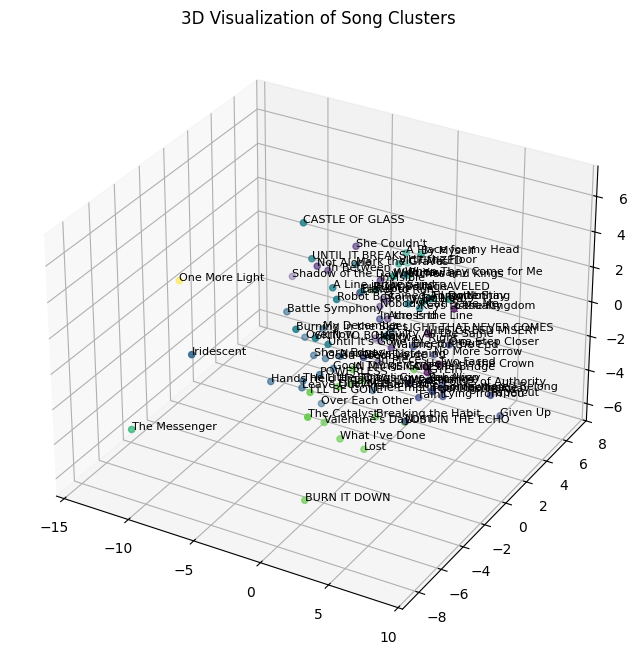

In [12]:

# Step 5: Visualize songs in 3D
song_reduced_3d = PCA(n_components=3).fit_transform(song_features)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(song_reduced_3d[:, 0], song_reduced_3d[:, 1], song_reduced_3d[:, 2], c=song_labels, cmap="viridis")
for i, name in enumerate(song_names):
    ax.text(song_reduced_3d[i, 0], song_reduced_3d[i, 1], song_reduced_3d[i, 2], name, fontsize=8)
ax.set_title("3D Visualization of Song Clusters")
song_img = save_plot_as_base64(fig)
plt.show()
plt.close(fig)


In [13]:

# Step 6: Aggregate album features
album_features_dict = defaultdict(list)
for feature, album in zip(song_features, album_names):
    if album:
        album_features_dict[album].append(feature)

# Compute the mean feature vector for each album
album_features = [np.mean(features, axis=0) for features in album_features_dict.values()]
album_names_unique = list(album_features_dict.keys())




In [14]:
# Step 7: Cluster albums
album_labels, album_reduced, _ = cluster_data(np.array(album_features), ALBUM_CLUSTERS, ALBUM_PCA_DIMENSIONS)

print_clusterwise_albums(album_labels, album_names_unique)


Clustering into 4 clusters...

Cluster-Wise Album Lists:
Cluster 2:
  - LIVING THINGS
  - A Thousand Suns
Cluster 0:
  - Minutes to Midnight
  - One More Light
Cluster 1:
  - Hybrid Theory
  - The Hunting Party
  - Meteora
Cluster 3:
  - From Zero


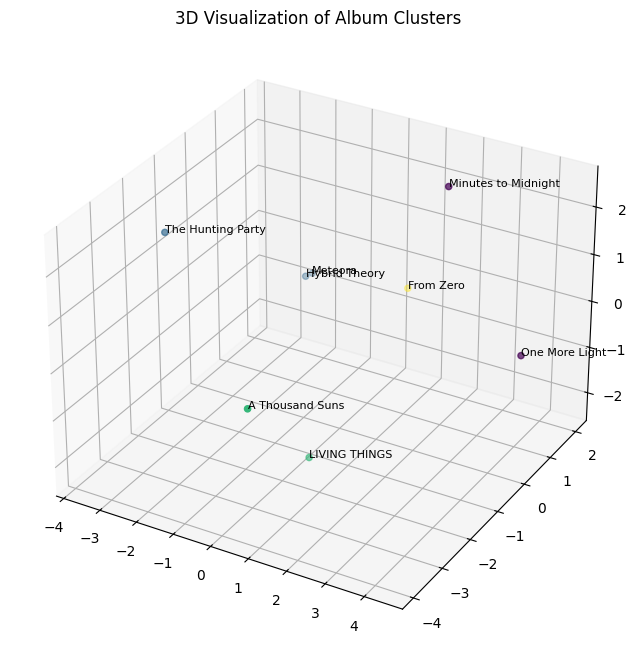

In [15]:
# Step 8: Visualize albums in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(album_reduced[:, 0], album_reduced[:, 1], album_reduced[:, 2], c=album_labels, cmap="viridis")
for i, name in enumerate(album_names_unique):
    ax.text(album_reduced[i, 0], album_reduced[i, 1], album_reduced[i, 2], name, fontsize=8)
ax.set_title("3D Visualization of Album Clusters")
album_img = save_plot_as_base64(fig)
plt.show()
plt.close(fig)


In [16]:

# Step 9: Album and song similarity data
album_similarity_data, song_to_album_similarity = generate_album_song_data(
    album_features, song_features, song_names, album_names_unique, album_names)

# Step 10: Generate HTML report
generate_html_report(ranked_songs, song_labels, album_labels, song_names, album_names_unique, song_img, album_img, album_similarity_data, song_to_album_similarity)


Generating album and song similarity data...
Generating HTML report...
Mapping songs to albums...
HTML report generated: linkin_park_clustering_report.html
